<table style="width:100%;">
    <tr>
        <td style="width:80%; text-align:left; vertical-align: center;">
            <img src="./Header/DoNotRemove.svg" alt="ETH logo" align="left" vspace="4">
        </td>
        <td style="width:20%; text-align:left; vertical-align: top;">
            Institute of Fluid Dynamics<br/>
            Prof. Dr. O. Supponen<br/>
        <img src="./Header/DoNotRemove2.jpg" alt="ETH logo2" align="left" vspace="4">
        </td>
    </tr>
</table>

<center> 
    <h1>Hydrodynamics and Cavitation: Lab Course</h1>
    <h3>by Eduard Meier</h3>
</center>

<center>
<img src="./Header/DoNotRemove3.png" alt="Cavitation" style="width: 700px;"/>
</center>

This Jupyter notebook contains all equations and code (main script and various functions) used to conduct and evaluate the lab session in the course "Hydrodynamics and Cavitation", held by Prof. Supponen in the autumn semester 2022.

In order to run this Jupyter notebook, OpenCV needs to be installed on your computer (required for the image analysis part)!

In [1]:
# Import libraries and other preliminaries
import numpy as np                            # Import numerical python library
from scipy.integrate import solve_ivp         # Import solver for (system of coupled) ODEs
import matplotlib as mpl                      # Import python mathematical plotting library
import matplotlib.pyplot as plt               # Import python mathematical plotting library
# For the following import to work, OpenCV has to be installed!
import cv2 as cv                              # Import library to process images
import glob                                   # Import library to scan paths
import pathlib                                # Import library to edit paths
import os                                     # Import library to interact with os
import skvideo.io                             # Import library to export video from captured images
import ffmpeg                                 # Import library to export video
import math                                   # Import math library
import warnings                               # Import library to edit warnings
warnings.filterwarnings("ignore")             
import io                                     # Import library to interact with io

# Use LaTeX font in plots:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computern Modern Roman'],
})

# 1 Preliminary Calculations

Within this laboratory session, the collapse of a laser-induced vapour bubble will be characterised through image processing, and compared to the results of the Keller-Miksis model. Both the rebound (radius-tracking) and the shock wave produced by the first collapse will be analysed. Finally, a solid surface will be placed near the location of the bubble inception and its effect on the collapse time will be assessed. Different groups of students work with slightly different laser powers and distances between the solid boundary and the cavitation bubble. Since phenomena of very different time scales are being imaged, some key measuring parameters need to be predetermined.
1. Determine the size of your Field Of View (FOV) by placing a small scale in the focus plane of the camera.
2. Knowing the approximate maximum bubble radius of the corresponding laser power, calculate the duration of the first collapse, first rebound and second collapse experienced by the cavitation bubble.
3. Based on the size of the previously computed FOV, find the time required for a shock wave originating at the bubble centre to reach the edge of the image.
4. Comparing the answers to questions 2 and 3, and considering that the Shimadzu high-speed camera saves 256 images per recording, determine an appropriate imaging frequency (i.e. # of frames per second) to image a) the bubble collapse and rebound until second collapse, and b) the shock wave resulting from the first collapse.
5. When imaging the shock wave: compute the required delay between the trigger of the laser pulse and the trigger of the camera.
6. Calculate the exposure time.

## 1.1 Field of View (FOV) Determination

A small scale was placed in the focus plane of the camera and an image was recorded. By selecting the length of two ticks on the scale (= 2 mm), the pixel density was calculated as 18 pixels per mm using the program ImageJ. Using the image resolution of 252 x 400 px, the FOV could be calculated.

In [2]:
PxDens = 18e3                                   # Pixel density based on image of scale [# of pixels/m]
Nx_Px = 400                                     # Total number of pixels in x-direction (horizontal)
Ny_Px = 252                                     # Total number of pixels in y-direction (vertical) 
FOV = np.array([Nx_Px/PxDens,Ny_Px/PxDens])     # Field of view, based on both axes [m]
print(r'The field of view is calculated as', '\033[1m' + 'FOV = {:.2f} x {:.2f}'\
      .format(FOV[0]*1e3, FOV[1]*1e3), 'mm.')

The field of view is calculated as FOV = 22.22 x 14.00 mm.


## 1.2 Calculation of the Duration of the
### i) First Collapse

The Rayleigh collapse time is given by (lecture notes p.110)

\begin{equation}
    t_c \approx 0.915 R_0 \sqrt{\frac{\rho}{p_\infty - p_v}}
\end{equation}

and is a good approximation for the time from formation until the first collapse of the cavitation bubble. It is assumed that the time from the laser induction until the bubble has been fully formed also corresponds to the Rayleigh collapse time.

In [3]:
# Define parameters
R_0 = 2e-3      # Approximate initial radius of the cavitation bubble of corresponding laser power [m]
rho = 997.77    # Water density at RT [kg/m^3]
p_v = 3169      # Water vapor pressure at RT [Pa]
p_infty = 1e5   # Ambient pressure [Pa]

In [4]:
# Calculate Rayleigh collapse time
t_c = 0.915 * R_0 * np.sqrt(rho/(p_infty-p_v))
# The time of formation and collapse is assumed to be twice the collapse time
t_fc = 2 * t_c
print(r'The formation and collapse time (duration of first bubble formation and collapse) is',\
      '\033[1m' + 't_fc = {:.2f}'.format(t_fc*1e3), 'ms')

The formation and collapse time (duration of first bubble formation and collapse) is t_fc = 0.37 ms


### ii) First Rebound

Considering the results from a numerical solution of the Keller-Miksis equation, which includes compressibility effects, and the Rayleigh-Plesset and collapse equations, which neglect compressibility, we see that only the first collapse of the cavitation bubble is accurately described by the collapse time, $t_c$, which is based on the Rayleigh collapse equation. This is a consequence of the shockwave emission during collapse, which reduces both the rebound time as well as subsequent collapse times (after the first collapse).

<center>
<img src="./Header/DoNotRemove4.pdf" alt="Plot" style="width: 200;"/>
</center>

Therefore, assuming Rayleigh-Plesset dynamics (i.e. undamped oscillations), the resulting rebound and second collapse times are upper bounds to the experimentally observed times. In the following, Rayleigh-Plesset dynamics are assumed for the preliminary calculations and it is further assumed that the Rayleigh collapse time reasonably approximates the first collapse time and is half of the rebound and a third of the 2nd collapse time (assuming a constant oscillation frequency).

Given the numerical solution of the Keller-Miksis equation, the collapse and rebound times could be more precisely determined by finding the local minima and maxima of the solution.

In [5]:
# Calculate formation collapse and rebound time (assuming undamped oscillation of constant frequency)
t_fcr = 3*t_c
print(r'The approximate formation collapse and rebound time is', \
      '\033[1m' +  't_fcr = {:.2f}'.format(t_fcr*1e3), 'ms')

The approximate formation collapse and rebound time is t_fcr = 0.56 ms


### iii) Second Collapse

In [6]:
# Calculate formation collapse rebound and second collapse time (assuming undamped oscillation of constant frequency)
t_fcrc = 4*t_c
print(r'The approximate formation collapse rebound and second collapse time is', \
      '\033[1m' +  't_fcrc = {:.2f}'.format(t_fcrc*1e3), 'ms')

The approximate formation collapse rebound and second collapse time is t_fcrc = 0.74 ms


## 1.3 Calculation of the Shock Wave Residence Time inside FOV

The velocity of the shock is assumed constant at the speed of sound in water, as defined below. As the velocity is constant, the FOV divided by the shock velocity yields the residence time of the shock inside the FOV.

As the velocity varies with the radial distance from the bubble, the mean velocity is used in the following to determine the residence time of the shock wave inside the FOV.

In [7]:
u_shock = 1500      # Shock velocity = speed of sound in water at RT [m/s] 

# Calculate time until shock wave reaches a vertical edge of FOV, originating from the center
t_shock = (FOV/2)/u_shock
print(r'The approximate time until the shock wave reaches the vertical',\
      '(i.e. right & left) \n and horizontal (i.e. upper & lower) edge of our FOV is', '\033[1m' +  't_shock = [{:.2f}, {:.2f}]'.format(t_shock[0]*1e6, t_shock[1]*1e6), 'mus')

The approximate time until the shock wave reaches the vertical (i.e. right & left) 
 and horizontal (i.e. upper & lower) edge of our FOV is t_shock = [7.41, 4.67] mus


## 1.4 Calculation of Imaging Frequency

In [8]:
# Define parameters
N_images = 256          # Total number of frames taken by camera per recording

### i) Bubble Collapse and Rebound until Second Rebound

In [9]:
# Calculation of requred imaging frequency 'frequency camera bubble'
t_cambubble = t_fcrc/256     # Time per frame to capture bubble dynamics until second rebound [s / # of frames]
f_cambubble = 1/t_cambubble  # Corresponding imaging frequency [# of frames / s]
print(r'The required imaging frequency to capture bubble dynamics until second rebound is',\
      '\033[1m' + 'f_cambubble = {:.2E}'.format(f_cambubble), 'fps')

The required imaging frequency to capture bubble dynamics until second rebound is f_cambubble = 3.45E+05 fps


### ii) Shock Wave Resulting from First Collapse

In [10]:
# Calculation of requred imaging frequency 'frequency camera shock'
t_camshock = t_shock/256     # Time per frame to capture bubble dynamics until second rebound
f_camshock = 1/t_camshock    # Corresponding imaging frequency
print(r'The required imaging frequency to capture shock wave for 1) horizontal FOV and 2) vertical FOV is',\
      '\033[1m' + 'f_camshock = [{:.2E}, {:.2E}]'.format(f_camshock[0], f_camshock[1]), 'fps')

The required imaging frequency to capture shock wave for 1) horizontal FOV and 2) vertical FOV is f_camshock = [3.46E+07, 5.49E+07] fps


## 1.5 Calculation of Delay between Laser Pulse and Camera Trigger for Shock Wave

The required time delay between the trigger of the laser pulse and the trigger of the camera is given by the Rayleigh collapse time of the cavitation bubble formed upon laser irradition, which has been calculated previously.

In [11]:
# Calculation of time delay
t_delay = t_fc
print(r'The required time delay is is', '\033[1m' + 't_delay = {:.2f}'.format(t_delay*1e3),\
      'ms = {:.2E}'.format(t_delay*1e9), 'ns')

The required time delay is is t_delay = 0.37 ms = 3.72E+05 ns


## 1.6 Calculation of the Exposure Time

The exposure time is given by the inverse of the frame rate multiplied by the number of frames and has been calculated in task 4.

In [12]:
print(r'The required exposure time to capture bubble dynamics until second rebound is t_cambubble = {:.2f}'\
      .format(t_cambubble*256*1e6), 'mus')
print(r'The required exposure time to capture the shock wave is t_camshock = [{:.2f},{:.2f}]'\
      .format(t_camshock[0]*256*1e9, t_camshock[1]*1e9), 'ns')

The required exposure time to capture bubble dynamics until second rebound is t_cambubble = 743.05 mus
The required exposure time to capture the shock wave is t_camshock = [7407.41,18.23] ns


# 2 Numerical Solution

Below you find the relevant equations and code to solve the Rayleigh Plesset and the Keller-Miksis equations numerically using 8th-order Runge-Kutta.

## 2.1 Rayleigh-Plesset Equation

The collapse time is calculated via:

\begin{equation}
    t_c \approx 0.915 R_0 \sqrt{\frac{\rho}{p_\infty - p_v}} \; .
\end{equation}

In [13]:
def t_collapse(R_0, rho, p_infty, p_v):
    """
    Calculate collapse time
    """
    return 0.915 * R_0 * np.sqrt(rho/(p_infty-p_v))

The Rayleigh-Plesset (RP) equation is a non-linear second-order ordinary differential equation and reads

\begin{align}
\rho \left( R \ddot{R} + \frac{3}{2}\dot{R}^2 \right) = (p_B - p_\infty) - \frac{2 \gamma}{R} - 4 \mu \frac{\dot{R}}{R} \; .
\end{align}

To solve the above ODE numerically, the second-order RP equation is reformulated as a system of 2 first-order ODEs by introducing an additional variable $R_1$. The following system of ODEs is thus numerically solved using an 8th-order Runge-Kutta (DOP853) scheme:

\begin{align}
\begin{cases}
    \dot{R} = R_1 \\
    \dot{R_1} = \frac{1}{\rho R} \left( (p_B - p_\infty ) - \frac{2 \gamma}{R} - 4 \mu \frac{R_1}{R} \right) - \frac{3}{2R} R_1^2
\end{cases}
\end{align}


The pressure inside the bubble required for the full Rayleigh-Plesset equation is calculated according to the following relation:

\begin{equation}
    p_B = p_g + p_v = p_{g0} \left( \frac{R_0}{R} \right)^{3 \kappa} + p_v
\end{equation}


and

\begin{equation}
p_\infty(t) = p_0 + p(t) \; .
\end{equation}

In [14]:
def pg(p_g0, R_0, kappa, R):
    """
    Calculate gas pressure
    """
    return p_g0*(R_0/R)**(3*kappa)

In [15]:
def RP_system(t, Rvec, Param, Task):
    """
    Create system of first-order non-linear ODEs for Rayleigh-Plesset equation
    
    Arguments:
        Rvec :  vector of the dependent "radius variables":
                  Rvec = [R,R1]
        Param :  vector of the parameters:
                  Param = [gamma, mu, rho, p_0, kappa, R_0, p_v, p_g0]
        Task: integer indicating the task number (1-5)
    """
    global tmax, tmin, trange
    
    # Extract input variables/parameters from input vectors
    R, R1 = Rvec
    gamma, mu, rho, p_0, kappa, R_0, p_v, p_g0 = Param

    # Set driving pressure for task 1)
    if (Task == 1):
        if (t < (tmax-tmin)/10):
            p = 0
        else: p = 0.1e5
    
    # Set driving pressure for task 2)
    if (Task == 2):
        if (t < (tmax-tmin)/10):
            p = 0
        else: p = 1e5
            
    # Set driving pressure for task 3)
    if (Task == 3):
        p = 0.1e5 * np.sin(t*(2*np.pi)*10e3)
        
    # Set driving pressure for task 4)
    if (Task == 4):
        p = 1e5 * np.sin(t*(2*np.pi)*10e3)
        
    # Set driving pressure for task 5) (assignment 8)
    if (Task == 5):
        p = 0
    
    # Calculate current p_B and p_infty values
    p_B = (p_0 + 2*gamma/R_0)*(R_0/R)**(3*kappa)
    p_infty = p_0 + p

    # Calculate p_B differently for assignment 8
    if (Task == 5):
        p_B = p_g0*(R_0/R)**(3*kappa) + p_v
    
    # Define system of ODEs, ode_system = [Rdot, R1dot]
    Rdot = R1
    R1dot =  1 /(rho*R)*((p_B-p_infty)-2*gamma/R-4*mu*R1/R) - 3/(2*R)*R1**2
    ode_system = [Rdot, R1dot]
    return ode_system

In [16]:
def RP_solve(Rvec_0, trange, Param, Task):
    """
    Numerically solve system of RP ODEs for given initial conditions (IC) and given parameter values (Param)
    over a given time interval (t)
    
    Arguments:
    Rvec_0 :  vector of the initial conditions:
                  IC = [R_0,R1_0]
    trange :  vector of times for evaluation
    Param :  vector of the parameters:
                  Param = [gamma, mu, rho, p_0, kappa, R_0, p_v, p_g0]
    Task : integer indicating the task number (1-5)
    """        
    # Solve system of ODEs (use 4th-5th order Runge-Kutta for time-integration)
    return solve_ivp(RP_system, [trange[0], trange[-1]], Rvec_0, args=(Param, Task), method='DOP853',
                     t_eval=trange)

## 2.2 Keller-Miksis Equation

In a subsequent step, the Keller-Miksis model is used, which additionally considers compressibility effects:

\begin{equation}
    \rho \left[ R \ddot{R} \left(1-\frac{\dot{R}}{c} \right) + \left(3-\frac{\dot{R}}{c} \right) \frac{\dot{R}^2}{2} \right] = \left(p_g + p_v - p_\infty \right) \left(1+\frac{\dot{R}}{c} \right) + \dot{p}_g \frac{R}{c}
\end{equation}

Together with

\begin{equation}
p_g = p_{g0} \left(\frac{R_0}{R} \right)^{3\kappa} \implies \dot{p}_g = 3 \kappa p_{g0} \left( \frac{R_0}{R} \right)^{3 \kappa - 1} \left( - \frac{R_0}{R^2} \right) \dot{R}
\end{equation}

the Keller-Miksis equation can be reformulated:

\begin{equation}
    \rho \left[ R \ddot{R} \left(1-\frac{\dot{R}}{c} \right) + \left(3-\frac{\dot{R}}{c} \right) \frac{\dot{R}^2}{2} \right] = \left(p_{g0} \left(\frac{R_0}{R} \right)^{3\kappa} + p_v - p_\infty \right) \left(1+\frac{\dot{R}}{c} \right) +  3 \kappa p_{g0} \left( \frac{R_0}{R} \right)^{3 \kappa - 1} \left( - \frac{R_0}{R^2} \right) \dot{R} \frac{R}{c}
\end{equation}

After conversion to a system of two first-order ODEs, we arrive at:

\begin{align}
\begin{cases}
    \dot{R} = R_1 \\
    \dot{R_1} =  \left(p_{g0} \left(\frac{R_0}{R} \right)^{3\kappa} + p_v + p_\infty \right) \frac{1}{\rho R} \frac{\left(1+\frac{R_1}{c} \right)}{\left(1-\frac{R_1}{c} \right)} + \frac{3\kappa p_{g0}}{\rho} \left( \frac{R_0}{R} \right)^{3 \kappa - 1} \left( - \frac{R_0}{R^2} \right) \dot{R} \frac{1}{c} \frac{1}{\left(1-\frac{R_1}{c} \right)} - \left(3-\frac{R_1}{c} \right) \frac{R_1^2}{2R} \frac{1}{\left(1-\frac{R_1}{c} \right)}
\end{cases}
\end{align}

In [17]:
def KM_system(t, Rvec, Param, Task):
    """
    Create system of first-order non-linear ODEs for Keller-Miksis equation
    
    Arguments:
        Rvec :  vector of the dependent "radius variables":
                  Rvec = [R,R1]
        Param :  vector of the parameters:
                  Param = [rho, p_0, p_v, p_g0, kappa, c, R_0]
        Task: integer indicating the task number (1-5)
    """
    global tmax, tmin, trange
    
    # Extract input variables/parameters from input vectors
    R, R1 = Rvec
    rho, p_0, p_v, p_g0, kappa, c, R_0 = Param

    # Set driving pressure for task 1) (assignment 7)
    if (Task == 1):
        if (t < (tmax-tmin)/10):
            p = 0
        else: p = 0.1e5
    
    # Set driving pressure for task 2) (assignment 7)
    if (Task == 2):
        if (t < (tmax-tmin)/10):
            p = 0
        else: p = 1e5
            
    # Set driving pressure for task 3) (assignment 7)
    if (Task == 3):
        p = 0.1e5 * np.sin(t*(2*np.pi)*10e3)
        
    # Set driving pressure for task 4) (assignment 7)
    if (Task == 4):
        p = 1e5 * np.sin(t*(2*np.pi)*10e3)
        
    # Set driving pressure for task 5) (assignment 8)
    if (Task == 5):
        p = 0
    
    # Calculate current p_B and p_infty values
    p_infty = p_0 + p
    
    # Define system of ODEs, ode_system = [Rdot, R1dot]
    Rdot = R1
    R1dot = (p_g0*(R_0/R)**(3*kappa)+p_v-p_infty)*1/(rho*R)*(1+R1/c)/(1-R1/c) + 3*kappa*p_g0/rho*(R_0/R)**(3*kappa-1)*(-R_0/R**2)*R1*1/c*1/(1-R1/c) - (3-R1/c)*R1**2/(2*R)*1/(1-R1/c)
    ode_system = [Rdot, R1dot]
    return ode_system

In [18]:
def KM_solve(Rvec_0, trange, Param, Task):
    """
    Numerically solve system of KM ODEs for given initial conditions (IC) and given parameter values (Param)
    over a given time interval (t)
    
    Arguments:
    Rvec_0 :  vector of the initial conditions:
                  IC = [R_0,R1_0]
    trange :  vector of times for evaluation
    Param :  vector of the parameters:
                  Param = [rho, p_0, p_v, p_g0, kappa, c, R_0]
    Task : integer indicating the task number (1-5)
    """        
    # Solve system of ODEs (use 4th-5th order Runge-Kutta for time-integration)
    return solve_ivp(KM_system, [trange[0], trange[-1]], Rvec_0, args=(Param, Task), method='DOP853', 
                     t_eval=trange)

# 3. Image & Data Analysis

## 3.1 Folder and File Detection

Detect folders and contained images.

In [19]:
paths = glob.glob(os.path.join('Image_Data','*'))

folders = list(range(len(paths)))   # Initialize folders list of same size as paths list

for path, i in zip(paths,range(len(paths))):
    folders[i] = pathlib.PurePath(path).name
    

imagenames = {} # Create dictionary (keys and corresponding values inserted later)
                # Works similarly to 'struct' in Matlab -> each key has corresponding value(s)
filelist = []   # Create list (files inserted later)


for path, folder in zip(paths, folders):
    filelist = []
    for file in glob.glob(os.path.join(path,'*.tiff')):
        filelist.append(file)
        filelist = sorted(filelist)
        imagenames[folder] = filelist

print('The following folders have been detected:', folders, ',\n', \
      'which each contain ', len(imagenames['Bubble']), 'elements that are stored under foldername keys',\
     'of the dictionary "imagenames".')     

The following folders have been detected: ['BubbleWall', 'Scale', 'Bubble', 'ShockWave'] ,
 which each contain  256 elements that are stored under foldername keys of the dictionary "imagenames".


## 3.2 Analysis of 1st Experiment: Pure Bubble Collapse

From the image of the scale, the pixel density was calculated as 18 pixels / mm. The frame rate was 400 kFPS and 256 frames were recorded in each measurement run. This results in a time step per image of 2.5 microseconds.

In [20]:
pxdens = 18e3    # Pixel density [pixels / m]
fps = 4e5        # Frame rate [# of frames / s]
N_frames = 256   # Total number of frames

tstep = (1/fps)*1e6   # Calculate time step of each frame [mus]

print('Timestep per frame:', tstep, 'mus')

Timestep per frame: 2.5 mus


Perform image analysis for the first measurement run ('bubble'). The laser was applied with a 40 $\mu$s delay (reduced intensity).

In [21]:
N_names = len(imagenames['Bubble'])

pxradius = np.zeros(N_names)

successcount = 0

for image, i in zip(imagenames['Bubble'], range(N_names)):
        
    imagevec = []
    titlevec = [] 
    
    imgraw = []
    imgcrop = []
    imgblur = []
    cimgproc = []

    # Image analysis pipeline
    imgraw = cv.imread(image, flags=cv.IMREAD_GRAYSCALE)[0:255, 0:255]
    
    imgcrop = cv.imread(image, flags=cv.IMREAD_GRAYSCALE)[60:190, 95:225]

    imgblur = cv.medianBlur(imgcrop, 11)
    

    # Circle detection via Hough Transform
    circles = cv.HoughCircles(imgblur,cv.HOUGH_GRADIENT,3.5,50,
                                param1=50,param2=30,minRadius=2,maxRadius=50)
    
    cimgproc = cv.cvtColor(imgblur,cv.COLOR_GRAY2BGR)
    
    
    # Define caption text (use 10 mus steps in the caption = 4 times the tstep)
    if i%4 == 1:
        caption_text = str(int((i-1)*tstep))+' us'
    elif i%4 == 2:
        caption_text = str(int((i-2)*tstep))+' us'
    elif i%4 == 3:
        caption_text = str(int((i-3)*tstep))+' us'
    else: 
        caption_text = str(int(i*tstep))+' us'
    
    
    # Add text to images
    cv.putText(imgraw, text=caption_text, org=(160, 230), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.7, color=(0, 0, 0),thickness=1)
    cv.putText(imgraw, text='Raw Image', org=(100, 25), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.7, color=(0, 0, 0),thickness=1)
    
    cv.putText(imgcrop, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    cv.putText(imgcrop, text='Zoom', org=(40, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    
    cv.putText(imgblur, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    cv.putText(imgblur, text='Median Filter', org=(8, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)

    
    # Save image analysis pipeline results
    filename = os.path.join('Image_Processed','Bubble','Pic'+str(i))
    cv.imwrite(filename+'_raw.png', imgraw)
    cv.imwrite(filename+'_crop.png', imgcrop)
    cv.imwrite(filename+'_blur.png', imgblur)
    
    
    # Initialize video
    if i == 0:
        out_video1 =  np.empty([N_names, imgraw.shape[0], imgraw.shape[1], 3], dtype = np.uint8)
        out_video1 =  out_video1.astype(np.uint8)
        out_video2 =  np.empty([N_names, imgblur.shape[0], imgblur.shape[1], 3], dtype = np.uint8)
        out_video2 =  out_video2.astype(np.uint8)
        out_video3 =  np.empty([N_names, imgblur.shape[0], imgblur.shape[1], 3], dtype = np.uint8)
        out_video3 =  out_video3.astype(np.uint8)
        out_video4 =  np.empty([N_names, imgblur.shape[0], imgblur.shape[1], 3], dtype = np.uint8)
        out_video4 =  out_video3.astype(np.uint8)
        
  
    # Save video from the images (for raw, cropped and blurred images)
    out_video1[i] = cv.cvtColor(imgraw,cv.COLOR_GRAY2BGR)
    out_video2[i] = cv.cvtColor(imgcrop,cv.COLOR_GRAY2BGR)
    out_video3[i] = cv.cvtColor(imgblur,cv.COLOR_GRAY2BGR)
      
    # Add detected circles to plot    
    if circles is not None:
        
        circles = np.uint16(np.around(circles))
        
        # Indicate successful circle detection
        outcome = 'successful'
        
        for j in circles[0,:]:
            
            center = (j[0], j[1])
            radius = j[2]
            red = (255, 0, 0)
            blue = (0, 0, 255)
            # Draw the outer circle
            cv.circle(cimgproc,center,radius,red,2)
            # Draw the center of the circle
            cv.circle(cimgproc,center,2,blue,2)
            
            # Save bubble radius
            pxradius[i] = radius # [pixels]
            
         
        # Add text to image
        cv.putText(cimgproc, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        cv.putText(cimgproc, text='Circles', org=(35, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        
        # Save image
        cv.imwrite(filename+'_circles.png', cimgproc)
      
        # Save video from the images (with circles)  
        out_video4[i] = cimgproc
    
    else:
        
        # Add text to image
        cv.putText(cimgproc, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        cv.putText(cimgproc, text='Circles', org=(35, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        
        # Save video from the images (without circles)  
        out_video4[i] = cimgproc
        
        # Indicate failed circle detection
        outcome = 'failed'
        
       
    if i == 0:
        print('Outcomes of the circle detection:')
    
    print('Image Number ', i+1, ':', outcome)


# Writes the the output image sequences to a video file
filename = os.path.join('Image_Processed','Bubble','Vid')
skvideo.io.vwrite(filename+'_raw_Lossless.mov', out_video1, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_raw.mov', out_video1, outputdict={"-vcodec":"mpeg2video"})
skvideo.io.vwrite(filename+'_crop_Lossless.mov', out_video2, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_crop.mov', out_video2, outputdict={"-vcodec":"mpeg2video"})
skvideo.io.vwrite(filename+'_blur_Lossless.mov', out_video3, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_blur.mov', out_video3, outputdict={"-vcodec":"mpeg2video"})
skvideo.io.vwrite(filename+'_circle_Lossless.mov', out_video4, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_circle.mov', out_video4, outputdict={"-vcodec":"mpeg2video"})


Outcomes of the circle detection:
Image Number  1 : failed
Image Number  2 : successful
Image Number  3 : successful
Image Number  4 : successful
Image Number  5 : successful
Image Number  6 : successful
Image Number  7 : successful
Image Number  8 : successful
Image Number  9 : successful
Image Number  10 : successful
Image Number  11 : successful
Image Number  12 : successful
Image Number  13 : successful
Image Number  14 : successful
Image Number  15 : successful
Image Number  16 : successful
Image Number  17 : successful
Image Number  18 : successful
Image Number  19 : successful
Image Number  20 : successful
Image Number  21 : successful
Image Number  22 : successful
Image Number  23 : successful
Image Number  24 : successful
Image Number  25 : successful
Image Number  26 : successful
Image Number  27 : successful
Image Number  28 : successful
Image Number  29 : successful
Image Number  30 : successful
Image Number  31 : successful
Image Number  32 : successful
Image Number  33 : 

Using the pixel density, the detected radius can be converted from pixels to meters and by additionally using the set framerate of the camera, the experimental radius-time curve is determined.

In [22]:
# Conversion from pixel radius to radius in meters
radius = pxradius / pxdens

# Determine max and collapse radius (and their indices) 
maxradius = np.max(radius)
collapseradius = 0

index_maxrad = np.where(radius==maxradius)[-1]
middleindex_maxrad = math.ceil(sum(index_maxrad)/len(index_maxrad))
lastindex_maxrad = index_maxrad[-1]

index_collapse = np.where(radius==collapseradius)[-1]
index_firstcollapse = index_collapse[1]

# Calculation of measurement time
tmax = N_frames / fps
tstep = 1 / fps

# Creation of time array (used for radius-time curve)
times = np.linspace(0, tmax, N_frames)

# Find zeros in array
idx_zeros = np.where(radius == 0)[0]
idx_zeros_2ndcollapse = np.where(idx_zeros > 186)[0]
idx_zeros = idx_zeros[idx_zeros_2ndcollapse]

# Only keep values up until second collapse
radius = radius[0:idx_zeros[0]+1]
times = times[0:idx_zeros[0]+1]

# Calculation of relative radius for plotting
relradius = radius/maxradius

# Find time corresponding to max radius and collapse radius
t_maxrad = times[middleindex_maxrad]
t_firstcollapse = times[index_firstcollapse]

Creation of a plot displaying the experimental and numerical results:

In [23]:
def plot1():
    """
    Plot numerical solutions of the Rayleigh-Plesset and Keller-Miksis equations and experimental results 
    """
    # Define initial conditions
    R_0 = 1.9e-3        # Initial bubble radius [m]
    Rdot_0 = 1e-10       # Initial change in radius [m/s]
    
    # Define parameter values
    kappa = 1.4       # Polytropic exponent = heat capacity ratio (adiabatic process -> kappa = gamma (air) = 1.4)
    gamma = 72e-3     # Water surface tension [N/m]
    mu = 0.89e-3      # Water dynamic viscosity at RT [Pa s]
    rho = 997.77      # Water density [kg/m^3]
    p_0 = 1e5         # Initial pressure (= 1 bar) [Pa]    
    p_g0 = 3          # Initial non-condensable gas pressure [Pa] -> fitted
    p_v = 3169        # Water vapor pressure at RT [Pa]
    c = 1500          # Speed of sound in water [m/s]
    
    # Include all initial conditions into a IC vector
    Rvec_0 = [R_0, Rdot_0]
   
    # Define time limits
    global tstep, tmax
    tmin = t_firstcollapse - t_collapse(R_0, rho, p_0, p_v)  # Starting time [s]
    #tmin = t_maxrad
    
    # Define time range
    trange = np.linspace(tmin, tmax, N_frames)
     
 
    # Include all parameter values into a parameter vector (we also need R_0 inside)
    Param_RP1 = [gamma, mu, rho, p_0, kappa, R_0, p_v, p_g0]
    Param_KM1 = [rho, p_0, p_v, p_g0, kappa, c, R_0]

    
    # Numerically solve the system of ODEs 
    Sol_RP1 = RP_solve(Rvec_0, trange, Param_RP1, 5)
    R_RP1 = Sol_RP1.y[0]
    R1_RP1 = Sol_RP1.y[1]

    Sol_KM1 = KM_solve(Rvec_0, trange, Param_KM1, 5)
    R_KM1 = Sol_KM1.y[0]
    R1_KM1 = Sol_KM1.y[1]
    

    # Create plots for LabSession Task 1)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5)) # Create figure with one plot
    
    # Subfigure 1
    plot1 = axs.plot(trange[0:len(R_RP1)]*1e3, R_RP1/R_0, color='k', linestyle='dashed', label='Rayleigh-Plesset Numerical (RK8)')
    plot2 = axs.plot(trange*1e3, R_KM1/R_0, color='b', linestyle='dashed', label='Keller-Miksis Numerical (RK8)')
    plot3 = axs.plot(times*1e3, relradius, color='r', marker='.', markersize='4', linestyle='none', label='Experimental (Hough Circle Transform)')

    # Add labels
    axs.set_xlabel(r'Time, $t$ [ms]', fontsize=16)
    axs.set_ylabel(r'Relative Bubble Radius, $R(t)/R_0$ [-]', fontsize=16)
 
    # Legend
    axs.legend(loc='lower left', fontsize=12)
    
    # Tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Save plot (w/o title)
    plt.savefig('./Plots/Plot_LabSess_Task1.pdf', bbox_inches='tight')
    
    # Titles
    fig.suptitle('Lab Session, Task 1', fontsize=16, y=1)   # Set overall title
    axs.set_title('Numerical methods included 8th-order Runge-Kutta (RK8)')


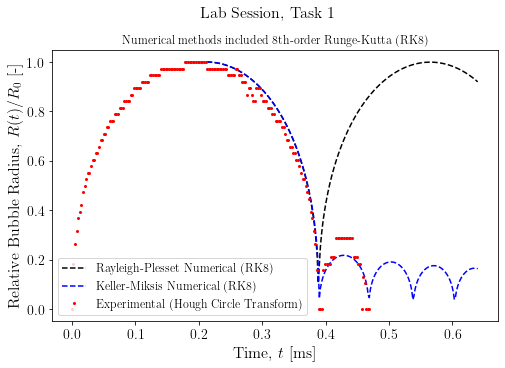

In [24]:
# Run plotting function
plot1()

## 3.2 Analysis of 2nd Experiment: Shock Wave

From the image of the scale, the pixel density was calculated as 18 pixels / mm. The frame rate was 10 MFPS and 256 frames were recorded in each measurement run. This results in a time step per image of 0.1 microseconds.

In [25]:
pxdens = 18e3    # Pixel density [pixels / m]
fps = 10        # Frame rate [Mio. frames / s]
N_frames = 256   # Total number of frames

tstep = 1/fps   # Calculate time step of each frame [mus]

print('Timestep per frame:', tstep, 'mus')

Timestep per frame: 0.1 mus


Perform image analysis for the second measurement run ('shockwave'). The laser was applied with a 40 $\mu$s delay (reduced intensity).

In [26]:
N_names = len(imagenames['ShockWave'])

pxradius = np.zeros(N_names)

circlecount = 0

previousradius = 0

successcount = 0

for image, i in zip(imagenames['ShockWave'], range(N_names)):
        
    # Image analysis pipeline      
    imgraw = cv.imread(image, flags=cv.IMREAD_GRAYSCALE)[0:255, 0:255]
        
    imgcrop = cv.imread(image, flags=cv.IMREAD_GRAYSCALE)[38:208, 65:235]
    
    imgblur = imgcrop - cv.GaussianBlur(imgcrop, ksize=(33, 33), sigmaX=3)+150
        
    #imgblur = cv.medianBlur(imgblur, 3)
    
    # Save image analysis pipeline results
    filename = os.path.join('Image_Processed','ShockWave','Pic'+str(i))
    cv.imwrite(filename+'_raw.png', imgraw)
    cv.imwrite(filename+'_blur.png', imgblur)

    
    if circlecount == 0:
        # Circle detection via Hough Transform
        circles = cv.HoughCircles(imgblur,cv.HOUGH_GRADIENT,3,130,
                                    param1=65,param2=50,minRadius=2,maxRadius=8)
        
    else:
        # Circle detection via Hough Transform
        circles = cv.HoughCircles(imgblur,cv.HOUGH_GRADIENT,3,130,
                                    param1=65,param2=25,minRadius=radius,maxRadius=maxnextradius)
        
    
    cimgproc = cv.cvtColor(imgblur,cv.COLOR_GRAY2BGR)
    
    # Define caption text (use 1 mus steps in the caption = 10 times the tstep)
    if i%10 == 1:
        caption_text = str(int((i-1)*tstep))+' us'
    elif i%10 == 2:
        caption_text = str(int((i-2)*tstep))+' us'
    elif i%10 == 3:
        caption_text = str(int((i-3)*tstep))+' us'
    elif i%10 == 4:
        caption_text = str(int((i-4)*tstep))+' us'
    elif i%10 == 5:
        caption_text = str(int((i-5)*tstep))+' us'
    elif i%10 == 6:
        caption_text = str(int((i-6)*tstep))+' us'
    elif i%10 == 7:
        caption_text = str(int((i-7)*tstep))+' us'
    elif i%10 == 8:
        caption_text = str(int((i-8)*tstep))+' us'
    elif i%10 == 9:
        caption_text = str(int((i-9)*tstep))+' us'
    else: 
        caption_text = str(int(i*tstep))+' us'
    
    
    # Add text to images
    cv.putText(imgraw, text=caption_text, org=(160, 230), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.7, color=(0, 0, 0),thickness=1)
    cv.putText(imgraw, text='Raw Image', org=(115, 25), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.7, color=(0, 0, 0),thickness=1)
    
    cv.putText(imgcrop, text=caption_text, org=(65, 155), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    cv.putText(imgcrop, text='Zoom', org=(58, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    
    cv.putText(imgblur, text=caption_text, org=(65, 155), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    cv.putText(imgblur, text='High Pass Filter', org=(14, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    
    if i == 0:
        out_video1 =  np.empty([N_names, imgraw.shape[0], imgraw.shape[1], 3], dtype = np.uint8)
        out_video1 =  out_video1.astype(np.uint8)        
        out_video2 =  np.empty([N_names, imgcrop.shape[0], imgcrop.shape[1], 3], dtype = np.uint8)
        out_video2 =  out_video2.astype(np.uint8)
        out_video3 =  np.empty([N_names, imgblur.shape[0], imgblur.shape[1], 3], dtype = np.uint8)
        out_video3 =  out_video3.astype(np.uint8)
        out_video4 =  np.empty([N_names, cimgproc.shape[0], cimgproc.shape[1], 3], dtype = np.uint8)
        out_video4 =  out_video3.astype(np.uint8)

    # Save video from the images (for raw, cropped and blurred images)
    out_video1[i] = cv.cvtColor(imgraw,cv.COLOR_GRAY2BGR)
    out_video2[i] = cv.cvtColor(imgcrop,cv.COLOR_GRAY2BGR)
    out_video3[i] = cv.cvtColor(imgblur,cv.COLOR_GRAY2BGR)

    
    if circles is not None:
        
        circles = np.uint16(np.around(circles))
        outcome = 'successful'
        
        # Increase circle counter if circle has been detected
        circlecount += 1
        
        for j in circles[0,:]:
            
            center = (j[0], j[1])
            radius = j[2]
            red = (255, 0, 0)
            blue = (0, 0, 255)
            # Draw the outer circle
            cv.circle(cimgproc,center,radius,red,2)
            # Draw the center of the circle
            cv.circle(cimgproc,center,2,blue,2)
            
            
            if 80 < j[0] < 90 and 80 < j[1] < 90 and i > 10:
                # Save bubble radius (if center is in a reasonable range)
                pxradius[i] = radius # [pixels]
            
            # Save upper limit for next radius (usse math.ceil to round up to an integer value)
            maxnextradius = math.ceil(1.2*radius)
            
        # Save image with circles    
        cv.imwrite(filename+'_circles.png', cimgproc)
        
        # Add text to image
        cv.putText(cimgproc, text=caption_text, org=(65, 155), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        cv.putText(cimgproc, text='Circles', org=(55, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        
      
        # Save video from the images (with circles)  
        out_video4[i] = cimgproc
    
    else:
        
        # Add text to image
        cv.putText(cimgproc, text=caption_text, org=(65, 155), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        cv.putText(cimgproc, text='Circles', org=(55, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        
        out_video4[i] = cimgproc
        outcome = 'failed'
   
       
    if i == 0:
        print('Outcomes of the circle detection:')
    
    print('Image Number ', i+1, ':', outcome)


# Writes the the output image sequences to a video file
filename = os.path.join('Image_Processed','ShockWave','Vid')
skvideo.io.vwrite(filename+'_raw_Lossless.mov', out_video1, outputdict={'-vcodec':'libx264','-preset':'veryslow'})
skvideo.io.vwrite(filename+'_raw.mov', out_video1, outputdict={'-vcodec':'mpeg2video'})
skvideo.io.vwrite(filename+'_crop_Lossless.mov', out_video2, outputdict={'-vcodec':'libx264','-preset':'veryslow'})
skvideo.io.vwrite(filename+'_crop.mov', out_video2, outputdict={'-vcodec':'mpeg2video'})
skvideo.io.vwrite(filename+'_blur_Lossless.mov', out_video3, outputdict={'-vcodec':'libx264','-preset':'veryslow'})
skvideo.io.vwrite(filename+'_blur.mov', out_video3, outputdict={'-vcodec':'mpeg2video'})
skvideo.io.vwrite(filename+'_circle_Lossless.mov', out_video4, outputdict={'-vcodec':'libx264','-preset':'veryslow'})
skvideo.io.vwrite(filename+'_circle.mov', out_video4, outputdict={'-vcodec':'mpeg2video'})

Outcomes of the circle detection:
Image Number  1 : successful
Image Number  2 : successful
Image Number  3 : successful
Image Number  4 : successful
Image Number  5 : successful
Image Number  6 : successful
Image Number  7 : successful
Image Number  8 : successful
Image Number  9 : successful
Image Number  10 : failed
Image Number  11 : failed
Image Number  12 : failed
Image Number  13 : failed
Image Number  14 : failed
Image Number  15 : failed
Image Number  16 : failed
Image Number  17 : failed
Image Number  18 : failed
Image Number  19 : failed
Image Number  20 : failed
Image Number  21 : failed
Image Number  22 : failed
Image Number  23 : failed
Image Number  24 : failed
Image Number  25 : failed
Image Number  26 : failed
Image Number  27 : failed
Image Number  28 : failed
Image Number  29 : failed
Image Number  30 : failed
Image Number  31 : failed
Image Number  32 : failed
Image Number  33 : successful
Image Number  34 : successful
Image Number  35 : successful
Image Number  36 

Using the pixel density, the detected radius can be converted from pixels to meters and by additionally using the set framerate of the camera, the experimental radius-time curve is determined.

In [27]:
# Conversion from pixel radius to radius in meters
radius = pxradius / pxdens

# Calculation of measurement time [mus]
tmax = N_names / fps
tstep = 1 / fps

# Creation of time array (used for radius-time curve)
times = np.linspace(0, tmax, N_names)*1e-6

# Read out non-zero index values for the (detected) radius
idxnonzero = np.nonzero(radius)

# Shorten the arrays, containing only non-zero elements
radius = radius[idxnonzero]
times = times[idxnonzero]

Creation of a plot displaying the experimental and theoretical results:

[1102.49784668 1102.49784668 1378.12230835 1102.49784668 1378.12230835
 1378.12230835 1653.74677003 2204.99569337 1653.74677003 1102.49784668
 1102.49784668 1929.3712317  1929.3712317  1378.12230835 1653.74677003
 1929.3712317  1378.12230835 1102.49784668 1653.74677003 2204.99569337
 2204.99569337]
1548.7469751035642


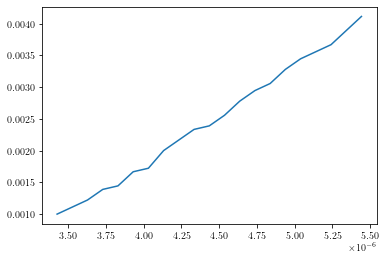

In [28]:
plt.plot(times, radius)

gradient = np.gradient(radius, times)

print(gradient)
print(np.mean(gradient))

In [29]:
def plot2():
    """
    Plot theoretical and experimental results 
    """   
    
    # Calculate theoretical radius of shockwave assuming it travelling at v = 1500 m/s (speed of sound in water)
    radius_th = (times-times[0])*u_shock + radius[0]
    
    # Create plot for LabSession Task 2)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 5)) # Create figure with one plot
    
    # Subfigure 1
    plot1 = axs.plot(times*1e6, radius_th*1e3, color='k', linestyle='dashed', label='Theoretical (Speed of Sound)')
    plot2 = axs.plot(times*1e6, radius*1e3, color='r', marker='o', markersize='4', linestyle='none', label='Experimental (Hough Circle Transform)')

    # Add labels
    axs.set_xlabel(r'Time, $t$ [$\mu$s]', fontsize=16)
    axs.set_ylabel(r'Shock Wave Radial Position, $R(t)$ [mm]', fontsize=16)
 
    # Legend
    axs.legend(loc='upper left', fontsize=12)
    
    # Tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Save plot (w/o title)
    plt.savefig('./Plots/Plot_LabSess_Task2.pdf', bbox_inches='tight')
    
    # Titles
    fig.suptitle('Lab Session, Task 2', fontsize=16, y=0.97)   # Set overall title

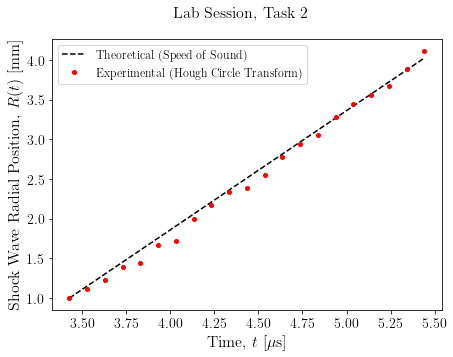

In [30]:
# Run plotting function
plot2()

## 3.3 Analysis of 3rd Experiment: Bubble Collapse with Wall

From the image of the scale, the pixel density was calculated as 18 pixels / mm. The frame rate was 400 kFPS and 256 frames were recorded in each measurement run. This results in a time step per image of 2.5 microseconds.

In [31]:
pxdens = 18e3    # Pixel density [pixels / m]
fps = 4e5        # Frame rate [# of frames / s]
N_frames = 256   # Total number of frames

tstep = (1/fps)*1e6   # Calculate time step of each frame [mus]

print('Timestep per frame:', tstep, 'mus')

Timestep per frame: 2.5 mus


Perform image analysis for the third measurement run ('bubblewall'). The laser was applied with a 40 $\mu$s delay (reduced intensity).

In [32]:
N_names = len(imagenames['BubbleWall'])

pxradius = np.zeros(N_names)

successcount = 0

for image, i in zip(imagenames['BubbleWall'], range(N_names)):
        
    imagevec = []
    titlevec = [] 
    
    imgraw = []
    imgcrop = []
    imgblur = []
    cimgproc = []

    # Image analysis pipeline
    imgraw = cv.imread(image, flags=cv.IMREAD_GRAYSCALE)[0:255, 0:255]
    
    imgcrop = cv.imread(image, flags=cv.IMREAD_GRAYSCALE)[60:190, 90:220]

    imgblur = cv.medianBlur(imgcrop, 11)
    

    # Circle detection via Hough Transform
    circles = cv.HoughCircles(imgblur,cv.HOUGH_GRADIENT,3.5,50,
                                param1=50,param2=30,minRadius=2,maxRadius=50)
    
    cimgproc = cv.cvtColor(imgblur,cv.COLOR_GRAY2BGR)
    
    
    # Define caption text (use 10 mus steps in the caption = 4 times the tstep)
    if i%4 == 1:
        caption_text = str(int((i-1)*tstep))+' us'
    elif i%4 == 2:
        caption_text = str(int((i-2)*tstep))+' us'
    elif i%4 == 3:
        caption_text = str(int((i-3)*tstep))+' us'
    else: 
        caption_text = str(int(i*tstep))+' us'
    
    
    # Add text to images
    cv.putText(imgraw, text=caption_text, org=(160, 230), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.7, color=(0, 0, 0),thickness=1)
    cv.putText(imgraw, text='Raw Image', org=(100, 25), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.7, color=(0, 0, 0),thickness=1)
    
    cv.putText(imgcrop, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    cv.putText(imgcrop, text='Zoom', org=(40, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    
    cv.putText(imgblur, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)
    cv.putText(imgblur, text='Median Filter', org=(8, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
               fontScale=0.5, color=(0, 0, 0),thickness=1)

    
    # Save image analysis pipeline results
    filename = os.path.join('Image_Processed','BubbleWall','Pic'+str(i))
    cv.imwrite(filename+'_raw.png', imgraw)
    cv.imwrite(filename+'_crop.png', imgcrop)
    cv.imwrite(filename+'_blur.png', imgblur)
    
    
    # Initialize video
    if i == 0:
        out_video1 =  np.empty([N_names, imgraw.shape[0], imgraw.shape[1], 3], dtype = np.uint8)
        out_video1 =  out_video1.astype(np.uint8)
        out_video2 =  np.empty([N_names, imgblur.shape[0], imgblur.shape[1], 3], dtype = np.uint8)
        out_video2 =  out_video2.astype(np.uint8)
        out_video3 =  np.empty([N_names, imgblur.shape[0], imgblur.shape[1], 3], dtype = np.uint8)
        out_video3 =  out_video3.astype(np.uint8)
        out_video4 =  np.empty([N_names, imgblur.shape[0], imgblur.shape[1], 3], dtype = np.uint8)
        out_video4 =  out_video3.astype(np.uint8)
        
  
    # Save video from the images (for raw, cropped and blurred images)
    out_video1[i] = cv.cvtColor(imgraw,cv.COLOR_GRAY2BGR)
    out_video2[i] = cv.cvtColor(imgcrop,cv.COLOR_GRAY2BGR)
    out_video3[i] = cv.cvtColor(imgblur,cv.COLOR_GRAY2BGR)
      
    # Add detected circles to plot    
    if circles is not None:
        
        circles = np.uint16(np.around(circles))
        
        # Indicate successful circle detection
        outcome = 'successful'
        
        for j in circles[0,:]:
            
            center = (j[0], j[1])
            radius = j[2]
            red = (255, 0, 0)
            blue = (0, 0, 255)
            # Draw the outer circle
            cv.circle(cimgproc,center,radius,red,2)
            # Draw the center of the circle
            cv.circle(cimgproc,center,2,blue,2)
            
            # Save bubble radius
            pxradius[i] = radius # [pixels]
            
         
        # Add text to image
        cv.putText(cimgproc, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        cv.putText(cimgproc, text='Circles', org=(35, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        
        # Save image
        cv.imwrite(filename+'_circles.png', cimgproc)
      
        # Save video from the images (with circles)  
        out_video4[i] = cimgproc
    
    else:
        
        # Add text to image
        cv.putText(cimgproc, text=caption_text, org=(40, 120), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        cv.putText(cimgproc, text='Circles', org=(35, 20), fontFace=cv.FONT_HERSHEY_TRIPLEX, \
                   fontScale=0.5, color=(0, 0, 0),thickness=1)
        
        # Save video from the images (without circles)  
        out_video4[i] = cimgproc
        
        # Indicate failed circle detection
        outcome = 'failed'
        
       
    if i == 0:
        print('Outcomes of the circle detection:')
    
    print('Image Number ', i+1, ':', outcome)


# Writes the the output image sequences to a video file
filename = os.path.join('Image_Processed','BubbleWall','Vid')
skvideo.io.vwrite(filename+'_raw_Lossless.mov', out_video1, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_raw.mov', out_video1, outputdict={"-vcodec":"mpeg2video"})
skvideo.io.vwrite(filename+'_crop_Lossless.mov', out_video2, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_crop.mov', out_video2, outputdict={"-vcodec":"mpeg2video"})
skvideo.io.vwrite(filename+'_blur_Lossless.mov', out_video3, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_blur.mov', out_video3, outputdict={"-vcodec":"mpeg2video"})
skvideo.io.vwrite(filename+'_circle_Lossless.mov', out_video4, outputdict={"-vcodec":"libx264"})
skvideo.io.vwrite(filename+'_circle.mov', out_video4, outputdict={"-vcodec":"mpeg2video"})


Outcomes of the circle detection:
Image Number  1 : failed
Image Number  2 : successful
Image Number  3 : successful
Image Number  4 : successful
Image Number  5 : successful
Image Number  6 : successful
Image Number  7 : successful
Image Number  8 : successful
Image Number  9 : successful
Image Number  10 : successful
Image Number  11 : successful
Image Number  12 : successful
Image Number  13 : successful
Image Number  14 : successful
Image Number  15 : successful
Image Number  16 : successful
Image Number  17 : successful
Image Number  18 : successful
Image Number  19 : successful
Image Number  20 : successful
Image Number  21 : successful
Image Number  22 : successful
Image Number  23 : successful
Image Number  24 : successful
Image Number  25 : successful
Image Number  26 : successful
Image Number  27 : successful
Image Number  28 : successful
Image Number  29 : successful
Image Number  30 : successful
Image Number  31 : successful
Image Number  32 : successful
Image Number  33 : 

Using the pixel density, the detected radius can be converted from pixels to meters and by additionally using the set framerate of the camera, the experimental radius-time curve is determined.

In [33]:
# Conversion from pixel radius to radius in meters
radius = pxradius / pxdens

# Determine max and collapse radius (and their indices) 
maxradius = np.max(radius)
collapseradius = 0

index_maxrad = np.where(radius==maxradius)[-1]
middleindex_maxrad = math.ceil(sum(index_maxrad)/len(index_maxrad))
lastindex_maxrad = index_maxrad[-1]

index_collapse = np.where(radius==collapseradius)[-1]
index_firstcollapse = index_collapse[1]

# Calculation of measurement time
tmax = N_frames / fps
tstep = 1 / fps

# Creation of time array (used for radius-time curve)
times = np.linspace(0, tmax, N_frames)

# Find zeros in array
idx_zeros = np.where(radius == 0)[0]
idx_zeros_2ndcollapse = np.where(idx_zeros > 180)[0]
idx_zeros = idx_zeros[idx_zeros_2ndcollapse]

# Only keep values up until second collapse
radius = radius[0:idx_zeros[0]+1]
times = times[0:idx_zeros[0]+1]

# Calculation of relative radius for plotting
relradius = radius/maxradius

# Find time corresponding to max radius and collapse radius
t_maxrad = times[middleindex_maxrad]
t_firstcollapse = times[index_firstcollapse]

Creation of a plot displaying the experimental and numerical results:

In [34]:
def plot3():
    """
    Plot numerical solutions of the Rayleigh-Plesset and Keller-Miksis equations and experimental results 
    """
    # Define initial conditions
    R_0 = 1.9e-3        # Initial bubble radius [m]
    Rdot_0 = 1e-10       # Initial change in radius [m/s]
    
    # Define parameter values
    kappa = 1.4       # Polytropic exponent = heat capacity ratio (adiabatic process -> kappa = gamma (air) = 1.4)
    gamma = 72e-3     # Water surface tension [N/m]
    mu = 0.89e-3      # Water dynamic viscosity at RT [Pa s]
    rho = 997.77      # Water density [kg/m^3]
    p_0 = 1e5         # Initial pressure (= 1 bar) [Pa]    
    p_g0 = 32          # Initial non-condensable gas pressure [Pa] -> fitted
    p_v = 3169        # Water vapor pressure at RT [Pa]
    c = 1500          # Speed of sound in water [m/s]
    
    # Include all initial conditions into a IC vector
    Rvec_0 = [R_0, Rdot_0]
   
    # Define time limits
    global tstep, tmax
    tmin = t_firstcollapse - t_collapse(R_0, rho, p_0, p_v)  # Starting time [s]
    #tmin = t_maxrad
    
    # Define time range
    trange = np.linspace(tmin, tmax, N_frames)
     
 
    # Include all parameter values into a parameter vector (we also need R_0 inside)
    Param_RP1 = [gamma, mu, rho, p_0, kappa, R_0, p_v, p_g0]
    Param_KM1 = [rho, p_0, p_v, p_g0, kappa, c, R_0]

    
    # Numerically solve the system of ODEs 
    Sol_RP1 = RP_solve(Rvec_0, trange, Param_RP1, 5)
    R_RP1 = Sol_RP1.y[0]
    R1_RP1 = Sol_RP1.y[1]

    Sol_KM1 = KM_solve(Rvec_0, trange, Param_KM1, 5)
    R_KM1 = Sol_KM1.y[0]
    R1_KM1 = Sol_KM1.y[1]
    

    # Create plots for LabSession Task 1)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5)) # Create figure with one plot
    
    # Subfigure 1
    plot1 = axs.plot(trange[0:len(R_RP1)]*1e3, R_RP1/R_0, color='k', linestyle='dashed', label='Rayleigh-Plesset Numerical (RK8)')
    plot2 = axs.plot(trange*1e3, R_KM1/R_0, color='b', linestyle='dashed', label='Keller-Miksis Numerical (RK8)')
    plot3 = axs.plot(times*1e3, relradius, color='r', marker='.', markersize='4', linestyle='none', label='Experimental (Hough Circle Transform)')

    # Add labels
    axs.set_xlabel(r'Time, $t$ [ms]', fontsize=16)
    axs.set_ylabel(r'Relative Bubble Radius, $R(t)/R_0$ [-]', fontsize=16)
 
    # Legend
    axs.legend(loc='lower left', fontsize=12)
    
    # Tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Save plot (w/o title)
    plt.savefig('./Plots/Plot_LabSess_Task3.pdf', bbox_inches='tight')
    
    # Titles
    fig.suptitle('Lab Session, Task 3', fontsize=16, y=1)   # Set overall title
    axs.set_title('Numerical methods included 8th-order Runge-Kutta (RK8)')


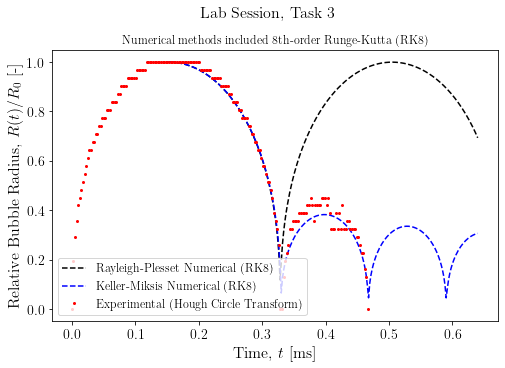

In [35]:
# Run plotting function
plot3()

In [36]:
# Find maximal radius
Rmax = np.max(radius)

# Define distance of wall from bubble center [m] (measured with ImageJ)
d = 5.55e-3

# Calculate Rayleigh prolongation factor
Rp = d/Rmax

print('The Rayleigh prolongation factor was found to be:', Rp)

The Rayleigh prolongation factor was found to be: 3.2225806451612904
